In [1]:
import matplotlib.pyplot as plt
import re
import shutil
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.preprocessing import label_binarize
import torchvision
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from PytMulticlass import Model_class
gpu_id = 1
!nvidia-smi

Wed Aug  4 21:05:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   50C    P2    61W / 250W |    859MiB / 11178MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   25C    P8     6W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
os.listdir('../../../dataset/sharma_59_nih_dataset/ham10000/dataset/HAM10000_images_part_1').__len__()

5000

In [3]:
files = ['HAM10000_metadata.csv',
 'HAM10000_images_part_2',
 'hmnist_28_28_RGB.csv',
 'ham10000_images_part_1',
 'ham10000_images_part_2',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_1',
 'hmnist_8_8_RGB.csv',
 'hmnist_28_28_L.csv']

In [4]:
link = '../../../dataset/sharma_59_nih_dataset/ham10000/dataset'
part1 = os.listdir(link+f"/{files[6]}")
part2 = os.listdir(link+f"/{files[1]}")
print(part1[:10],part2[:10])
part = part1+part2

['ISIC_0024312.jpg', 'ISIC_0026226.jpg', 'ISIC_0026148.jpg', 'ISIC_0025073.jpg', 'ISIC_0024463.jpg', 'ISIC_0028232.jpg', 'ISIC_0027785.jpg', 'ISIC_0027176.jpg', 'ISIC_0027461.jpg', 'ISIC_0025331.jpg'] ['ISIC_0030094.jpg', 'ISIC_0030526.jpg', 'ISIC_0034059.jpg', 'ISIC_0029713.jpg', 'ISIC_0032675.jpg', 'ISIC_0032830.jpg', 'ISIC_0033954.jpg', 'ISIC_0030889.jpg', 'ISIC_0030239.jpg', 'ISIC_0033540.jpg']


In [5]:
df1 = pd.read_csv(link+'/HAM10000_metadata.csv')
print(df1.shape)

df1.head()

(10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
np.unique(np.array(df1.iloc[:,2]),return_counts=True)

(array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object),
 array([ 327,  514, 1099,  115, 1113, 6705,  142]))

In [7]:
np.unique(np.array(df1.iloc[:,3]),return_counts=True)

(array(['confocal', 'consensus', 'follow_up', 'histo'], dtype=object),
 array([  69,  902, 3704, 5340]))

In [8]:
np.unique(np.array(df1.iloc[:,-1]),return_counts=True)

(array(['abdomen', 'acral', 'back', 'chest', 'ear', 'face', 'foot',
        'genital', 'hand', 'lower extremity', 'neck', 'scalp', 'trunk',
        'unknown', 'upper extremity'], dtype=object),
 array([1022,    7, 2192,  407,   56,  745,  319,   48,   90, 2077,  168,
         128, 1404,  234, 1118]))

In [9]:
len(part)

10015

In [10]:
# img_id = np.array(df1.iloc[:,1])
# lables = np.array(df1.iloc[:,2])
# for i,value in enumerate(img_id):

# for i in range(len(part)):
#     part[i] = part[i][:-4]
# another_df = df1.loc[df1['image_id'].isin(part),:]

# another_df.shape
    


In [11]:

# for images in part1:
#     shutil.copy(link+f'/{files[6]}/{images}',link+'/HamImages')

# for images in part2:
#     shutil.copy(link+f'/{files[1]}/{images}',link+'/HamImages')

In [12]:
part3 = os.listdir(link+'/HamImages')
for i in range(len(part3)):
    part3[i] = part3[i][:-4]
my_df = df1.loc[df1['image_id'].isin(part3),:]
my_df.shape

(10015, 7)

In [13]:
# AllImages =os.listdir(link+'/HamImages')
# for i in range(len(AllImages)):
#     AllImages[i] = AllImages[i][:-4]

# for i,value in enumerate(AllImages):
#     val = list(df1.loc[df1['image_id']==value,'dx'])
#     shutil.copy(link+f'/HamImages/{value}.jpg',link+f'/HamDataset/{val[0]}/{value}.jpg')

In [14]:
point = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
l = []
for i in point:
    data = os.listdir(link+f'/HamDataset/{i}')
    l.append(len(data))
print(l)

[327, 514, 1099, 115, 1113, 6705, 142]


In [15]:
my_path = '../../../dataset/sharma_59_nih_dataset/ham10000/dataset/HamDataset'
for i in os.listdir(my_path):
    print(len(os.listdir(my_path+f'/{i}')))


# torchvision.transforms.Normalize(mean=torch.rand(3),std = torch.rand(3))
transformations = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor()])

images = torchvision.datasets.ImageFolder(root=my_path,transform=transformations)
train_data,validate_data,test_data = torch.utils.data.dataset.random_split(images,[7000,2000,1015])
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=64,shuffle=True)
validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=64,shuffle=True)


print(images.class_to_idx)

# root_dir = 'LatestSavedModels/'


327
115
514
6705
1113
142
1099
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [16]:
images,labels = next(iter(train_loader))
print(torch.max(images))

tensor(1.)


tensor(5)


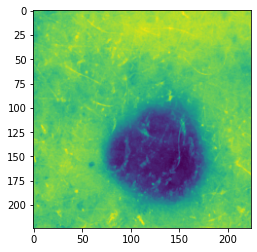

In [17]:
plt.imshow(images[0][1])
print(labels[0])

In [18]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True) # data again divided by 255

squeezenet.features[3].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[3].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[4].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[4].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[5].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[5].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[7].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[7].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[8].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[8].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[9].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[9].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[10].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[10].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.features[12].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[12].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.classifier[1] = nn.Conv2d(512, 7, kernel_size=(1, 1), stride=(1, 1))
print(squeezenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), groups=16)
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), groups=16)
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
      (expand3x3_activation):

In [19]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=squeezenet.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=26,gamma=0.1)
n_epochs=30

model = Model_class(squeezenet,num_classes=7,gpu_id=gpu_id)
model.print_params()
print()
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

total_trainable_parameters are : 137415

one of the best validation acc found
epoch:[1/30],memory:[0.5243711471557617/10.91650390625], lr:[0.0003]
train_accuracy:0.6682765153321353, train_loss:1.2081625066020272
val_acc:0.6787109375,val_loss:1.0280812606215477

one of the best validation acc found
epoch:[2/30],memory:[0.5254483222961426/10.91650390625], lr:[0.0003]
train_accuracy:0.6717329545454546, train_loss:1.0240293887528507
val_acc:0.68212890625,val_loss:0.9765344057232141

epoch:[3/30],memory:[0.5254483222961426/10.91650390625], lr:[0.0003]
train_accuracy:0.6767045454545455, train_loss:0.990010657635602
val_acc:0.6796875,val_loss:0.9869585447013378

one of the best validation acc found
epoch:[4/30],memory:[0.5254483222961426/10.91650390625], lr:[0.0003]
train_accuracy:0.6723958335139535, train_loss:0.9897529775446111
val_acc:0.68701171875,val_loss:0.9481757543981075

one of the best validation acc found
epoch:[5/30],memory:[0.5254483222961426/10.91650390625], lr:[0.0003]
train_ac

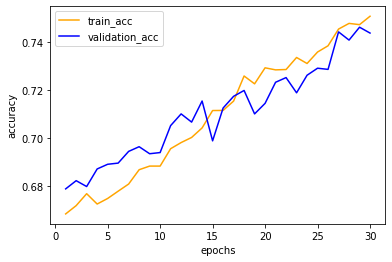

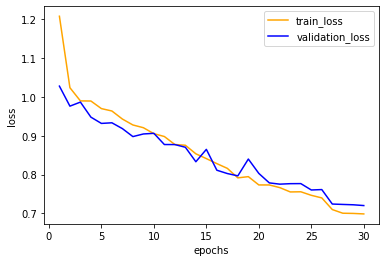

In [20]:
model.accuracy_curve()
model.loss_curve()

correct are 5234/7000
tensor(0.7477)


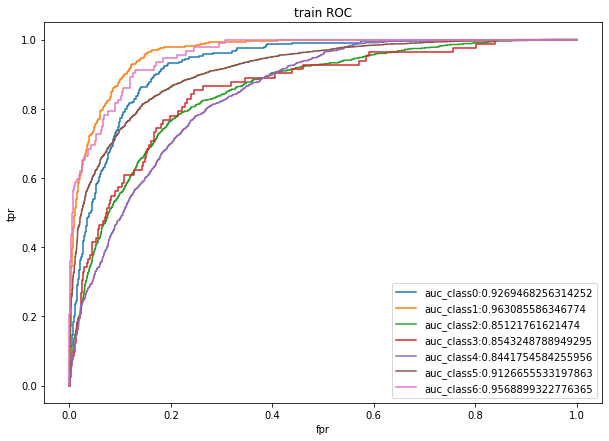

correct are 750/1015
tensor(0.7389)


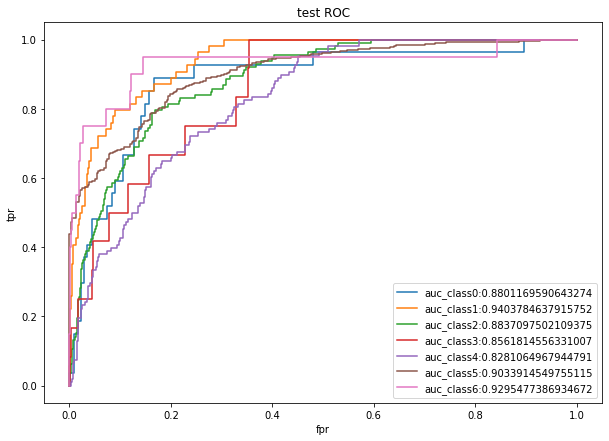

In [21]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print(acc_train)
model.plot_roc(fig_size=(10,7),name='train')
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print(acc_test)
model.plot_roc(fig_size=(10,7),name='test')


In [23]:
# message = {'model':'squilenet'}

# model.save_model(directory = 'squeeze_mob_v1.pth',message=message)
# model.save_best_model(directory='squeeze_mob_v1_best.pth',message=message)

model saved
model saved


In [18]:
mob_v2 = torchvision.models.mobilenet_v2(pretrained=True)
mob_v2.classifier[0] = nn.Dropout(p=0.3)
mob_v2.classifier[1] = nn.Linear(in_features=1280,out_features=7,bias=True)
print(mob_v2)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [19]:
Losses_ = nn.CrossEntropyLoss() # not again divided by 255
lr = 0.0001
optimizer = optim.Adam(params=mob_v2.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=26,gamma=0.1)
n_epochs=30

model = Model_class(mob_v2,num_classes=7,gpu_id=gpu_id)
model.print_params()
print()
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

total_trainable_parameters are : 2232839

one of the best validation acc found
epoch:[1/30],memory:[0.8498849868774414/10.91650390625], lr:[0.0001]
train_accuracy:0.7477272727272727, train_loss:0.819512908838012
val_acc:0.783203125,val_loss:0.6325904037803411

one of the best validation acc found
epoch:[2/30],memory:[0.8794727325439453/10.91650390625], lr:[0.0001]
train_accuracy:0.8478219698775898, train_loss:0.5023981229825454
val_acc:0.8125,val_loss:0.5591678889468312

epoch:[3/30],memory:[0.8755435943603516/10.91650390625], lr:[0.0001]
train_accuracy:0.896875, train_loss:0.379593865302476
val_acc:0.8125,val_loss:0.5589883849024773

one of the best validation acc found
epoch:[4/30],memory:[0.8755435943603516/10.91650390625], lr:[0.0001]
train_accuracy:0.9427083335139534, train_loss:0.2580642694099383
val_acc:0.8173828125,val_loss:0.5836022412404418

one of the best validation acc found
epoch:[5/30],memory:[0.8775348663330078/10.91650390625], lr:[0.0001]
train_accuracy:0.9677556818181

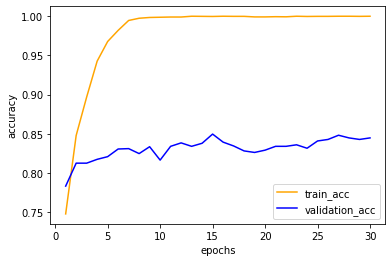

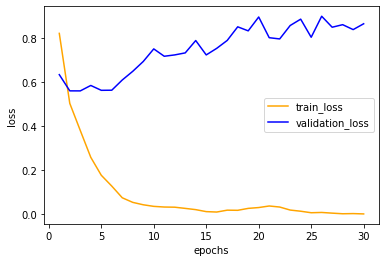

In [20]:
model.accuracy_curve()
model.loss_curve()

correct are 7000/7000
tensor(1.)


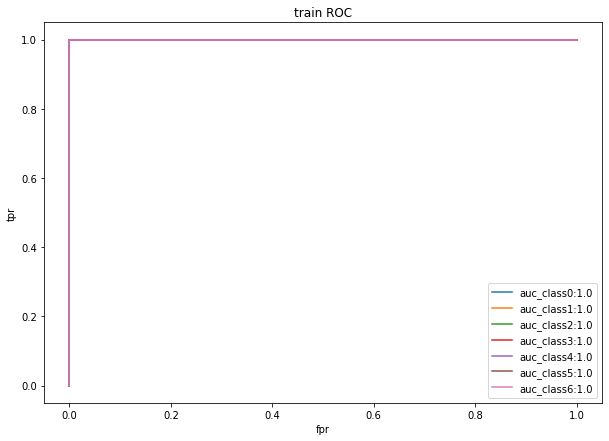

correct are 857/1015
tensor(0.8443)


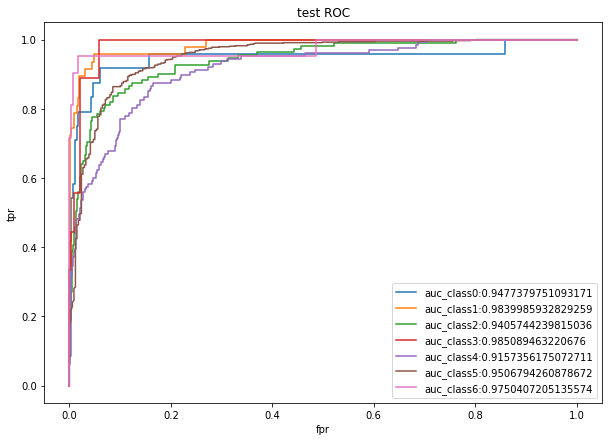

In [21]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print(acc_train)
model.plot_roc(fig_size=(10,7),name='train')
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print(acc_test)
model.plot_roc(fig_size=(10,7),name='test')